<a href="https://colab.research.google.com/github/o-bollverk/msf/blob/main/nomm_cnn_with_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from urllib.request import urlopen
from fastai.vision import *
from fastai.metrics import error_rate
from PIL import Image
from google.colab import drive
from os import listdir
import numpy as np 
import cv2
from matplotlib import image
from matplotlib import pyplot
import numpy as np
import warnings



Klassid:

Airbus A320neo

Boeing 747-8 Intercontinental

Aviat Pitts Special S2S

Cub Crafter X Cub

Daher TBM 930

Diamond DA40NG

Diamond DA62

EXTRA 330LT



https://www.windowscentral.com/list-microsoft-flight-simulator-planes


Cloning the repository

In [3]:
# Clone the entire repo.
!git clone -l -s git://github.com/o-bollverk/msf cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 4517, done.
remote: Counting objects: 100% (4517/4517), done.
remote: Compressing objects: 100% (4124/4124), done.
remote: Total 100380 (delta 396), reused 4510 (delta 393), pack-reused 95863
Receiving objects: 100% (100380/100380), 5.29 GiB | 41.36 MiB/s, done.
Resolving deltas: 100% (463/463), done.
Checking out files: 100% (71762/71762), done.
/content/cloned-repo
all_data_bw			       msf_project1.ipynb
all_data_color			       msf_project1_mixed.ipynb
colab				       msf_project2.ipynb
convert_images.ipynb		       nomm_cnn.ipynb
convert_to_bw.ipynb		       random_selection_augmented
data_amounts			       random_selection_augmented_jpg
ludvig_local_msf_project1_mixed.ipynb  tausta_eemaldus_gen.ipynb
msf_data			       web_data_links


In [4]:
! git pull

Already up to date.


In [5]:
nimede_vastavus = pd.DataFrame({"web_name": np.sort(listdir("all_data_color/")),
                                "game_name": np.sort(np.unique([x.split("_clear")[0] for x in listdir("msf_data/image_data_clear")]))})

In [6]:
! mkdir random_selection_train
! mkdir random_selection_test


In [7]:
# creating temporary folder for selected files
from shutil import copyfile
import random
import shutil

selection_size_web = 250
selection_size_web_test = int(0.1*selection_size_web)

def abifun(x):
    return x[:len(nimede_vastavus.game_name[i])] == nimede_vastavus.game_name[i]
 
for i in range(nimede_vastavus.shape[0]):
  web_files = listdir("all_data_color/" + nimede_vastavus.web_name[i])
  game_files_clear = listdir("msf_data/image_data_clear/")    
  game_files_clear_selected = np.array(game_files_clear)[[abifun(x) for x in game_files_clear]]
  game_files_rainy = listdir("msf_data/image_data_rainy/")
  game_files_rainy_selected = np.array(game_files_rainy)[[abifun(x) for x in game_files_rainy]]
  
  # making a random selection

  selected_web = random.sample(web_files, selection_size_web)
  selected_web2 = ["all_data_color/" + nimede_vastavus.web_name[i] + "/" + x for x in selected_web]
  selected_web2_test = selected_web2[0:selection_size_web_test]
  selected_web2_train = selected_web2[selection_size_web_test:]

  selected_clear = random.sample(set(game_files_clear_selected), int(selection_size_web/4))
  selected_clear2 = ["msf_data/image_data_clear/" + x for x in selected_clear]
  selected_clear2_test = selected_clear2[0:selection_size_web_test]
  selected_clear2_train = selected_clear2[selection_size_web_test:]

  selected_rainy = random.sample(set(game_files_rainy_selected), int(selection_size_web/4))
  selected_rainy2 = ["msf_data/image_data_rainy/" + x for x in selected_rainy]
  selected_rainy2_test = selected_rainy2[0:selection_size_web_test]
  selected_rainy2_train = selected_rainy2[selection_size_web_test:]
  
#complete_selection_train = np.concatenate([selected_web2, selected_clear2, selected_rainy2])
#complete_selection_test = np.concatenate([selected_web2_test, selected_clear2_test, selected_rainy2_test])
  complete_selection_train = np.concatenate([selected_web2_train, selected_clear2_train, selected_rainy2_train])
  complete_selection_test = np.concatenate([selected_web2_test, selected_clear2_test, selected_rainy2_test])

  os.mkdir("random_selection_train/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_train:
    shutil.copy(filename, "random_selection_train/" +  nimede_vastavus.game_name[i])

  os.mkdir("random_selection_test/" +  nimede_vastavus.game_name[i])
  for filename in complete_selection_test:
    shutil.copy(filename, "random_selection_test/" +  nimede_vastavus.game_name[i])



In [11]:
# data augmentation
def median_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      img = tf.image.convert_image_dtype(img, tf.dtypes.float32)
      #img = tf.image.resize(img, [500,500])
      mean = tfa.image.mean_filter2d(img, filter_shape=5)
      return mean

def wrap_transform(img_raw):
      img = tf.io.decode_image(img_raw)
      input_img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
      flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
      init_flows = np.float32(np.random.normal(size=flow_shape) * 2.0)
      dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
      dense_img_warp = tf.squeeze(dense_img_warp, 0)
      return dense_img_warp

def random_hsv(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = tf.image.convert_image_dtype(tf.expand_dims(img, 0), tf.dtypes.float32)
    delta = 0.5
    lower_saturation = 0.1
    upper_saturation = 0.9
    lower_value = 0.2
    upper_value = 0.8
    delta = 0.5
#    saturation = 0.3
    value = 0.6
    #adj_hsvinyiq = tfa.image.adjust_hsv_in_yiq(img, delta, saturation, value)

    rand_hsvinyiq = tfa.image.random_hsv_in_yiq(img, delta, lower_saturation, upper_saturation, lower_value, upper_value)
    return rand_hsvinyiq
    #return adj_hsvinyiq

def rotate(img_raw):
    img = tf.io.decode_image(img_raw)
    #img = img_raw
    img = tf.image.convert_image_dtype(img, tf.float32)
    rotated = tfa.image.rotate(img, tf.constant(np.pi/8))
    return rotated

In [12]:
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from PIL import Image

# With the entire training set and training after that:
# No resizing at this point

def image_folder_filter(input_folder, output_folder, method):
  
  input_folder = input_folder + "/"
  output_folder = output_folder + "/"
  folders = listdir(input_folder)
  if os.path.isdir(output_folder) == False:
    try: 
      os.mkdir(output_folder)
    except OSError:
      print("Creation of the directory '" + output_folder + "' failed")

  for folder_name in folders:
    folder_name = folder_name + "/"
    files_in_folder = listdir(input_folder + folder_name)

    if os.path.isdir(output_folder + folder_name) == False:
      try: 
        os.mkdir(output_folder + folder_name)
      except OSError:
        print("Creation of the directory '" + output_folder + folder_name + "' failed")

    for filename in files_in_folder:
      img_raw = tf.io.read_file(input_folder + folder_name + filename)
      if method == "median":
        transformed_result = median_transform(img_raw)
      elif method == "wrap":
        transformed_result = wrap_transform(img_raw)
      elif method == "random_hsv":
        transformed_result = random_hsv(img_raw)
      elif method == "rotate":
        transformed_result = rotate(img_raw)

      tf.keras.preprocessing.image.save_img( output_folder + folder_name + filename, transformed_result)

In [16]:
image_folder_filter("random_selection_train", "random_selection_train_mean", method = "median")
image_folder_filter("random_selection_test", "random_selection_test_mean", method = "median")
image_folder_filter("random_selection_train", "random_selection_train_wrap", method = "wrap")
image_folder_filter("random_selection_test", "random_selection_test_wrap", method = "wrap")
#image_folder_filter("random_selection_train", "random_selection_train_random_hsv", method = "random_hsv")
#image_folder_filter("random_selection_test", "random_selection_test_random_hsv", method = "random_hsv")
#image_folder_filter("random_selection_train", "random_selection_train_rotate", method = "rotate")
#image_folder_filter("random_selection_test", "random_selection_test_rotate", method = "rotate")

In [17]:
path = Path("random_selection_train")

In [18]:
# loading train data
import cv2
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os, sys

d = {}
x=['aviat', 'diamond40ng', 'cessna_172', 'cessna_cj', 'boeing', 'diamondda62', 'airbus', 'cessna_208', 'extra', 'daher', 'cubcraft', 'cessna_152']
count = 0
for i in x:
  if i not in d:
     d[i] = count
     count += 1
actual = []
X_train = []
y_train = []
IMG_SIZE = (64, 64)
for i in listdir("random_selection_train"):
  for j in listdir("random_selection_train" + "/" + i):
    actual.append(i)
    a = cv2.imread("random_selection_train/" + i +"/" + j)
    y_train.append(d[i])
    resized = cv2.resize(a, IMG_SIZE)
    X_train.append(resized)
    #plt.imshow(a)
    #plt.show()
    #print(a.shape)

X_train = np.array(X_train)
y_train = np.array(y_train)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

Train data shape:  (3588, 64, 64, 3)
Train labels shape:  (3588,)


In [19]:
# loading test data
from keras.utils import to_categorical

actual = []
X_test = []
y_test = []
IMG_SIZE = (64, 64)
for i in listdir("random_selection_test"):
  for j in listdir("random_selection_test" + "/" + i):
    actual.append(i)
    a = cv2.imread("random_selection_test/" + i +"/" + j)
    y_test.append(d[i])
    resized = cv2.resize(a, IMG_SIZE)
    X_test.append(resized)


X_test = np.array(X_test)
y_test = np.array(y_test)
print('Train data shape: ', X_test.shape)
print('Train labels shape: ', y_test.shape)
y_test_one_hot = to_categorical(y_test)

Train data shape:  (900, 64, 64, 3)
Train labels shape:  (900,)


## Train model

In [24]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving cnn_architecture (1).jpg to cnn_architecture (1).jpg


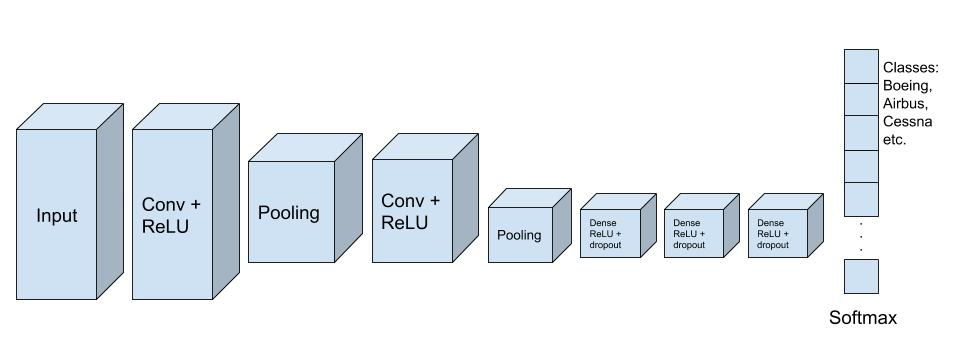

In [26]:
Image("cnn_architecture (1).jpg")

In [27]:
%tensorflow_version 1.x
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(64, (1, 1), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)

y_train_one_hot = to_categorical(y_train)

history = model.fit(X_train, y_train_one_hot, batch_size=64, epochs=128, validation_split=0.1)

TensorFlow is already loaded. Please restart the runtime to change versions.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       8320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              32769000  
_____________________________________________

In [28]:
# accuracy in train data
model.evaluate(X_train, y_train_one_hot)

113/113 [==============================] - 10s 88ms/step - loss: 1.6895 - accuracy: 0.8857


[1.6895089149475098, 0.8857302069664001]

In [29]:
# accuracy in test data
test_result = model.evaluate(X_test, y_test_one_hot)

29/29 [==============================] - 2s 84ms/step - loss: 4.2085 - accuracy: 0.6456


Text(0.5, 1.0, 'Accuracy')

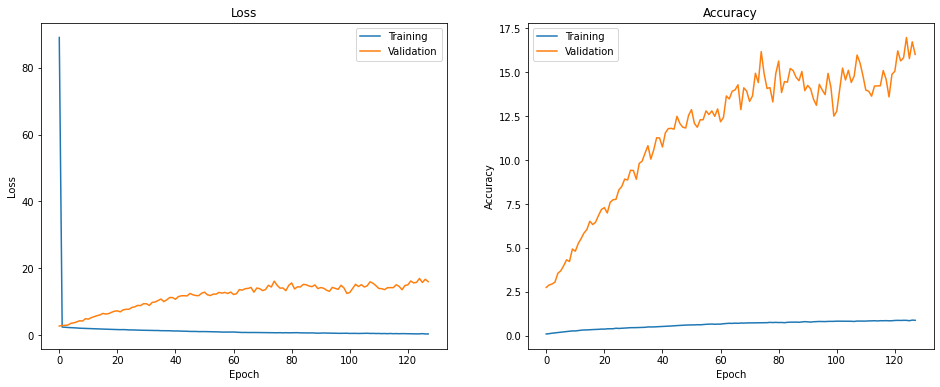

In [30]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

The model is overfitted, however the model is still learning. Train data returns ca 90% accuracy and test data ca 65% accuracy. Data augmentation slightly improved the results, however only median transformation and wrap transforming was used.